# 模态I CHAMBER=4 conv1 虚拟量测 conv1d model[ok]

In [1]:
# 导入包
# This makes it so that matplotlib graphics will show up within the Jupyter Notebook.
%matplotlib inline

# Standard library import

# Data Analysis Tools
import pandas as pd
import numpy as np

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Tools

# File Loading Tools 
import os

import pickle

## 导入模态I腔室4的训练数据和测试数据

In [2]:
X_train = np.load("./data phm 2016/X_train_r_modeI_chamber4_mm.npy")
y_train = np.load("./data phm 2016/y_train_modeI_chamber4_mm.npy")
X_test = np.load("./data phm 2016/X_test_r_modeI_chamber4_mm.npy")
y_test = np.load("./data phm 2016/y_test_modeI_chamber4_mm.npy")
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (798, 263, 19)
y_train shape:  (798, 1)
X_test shape:  (165, 263, 19)
y_test shape:  (165, 1)


In [3]:
# 基本参数
wafer_number, max_batch_length, variable_number = X_train.shape
wafer_number_test = X_test.shape[0]
print('训练集晶圆个数：', wafer_number)
print('最长时间序列长度：', max_batch_length)
print('字段个数：', variable_number)
print('训练集晶圆个数：', wafer_number_test)

训练集晶圆个数： 798
最长时间序列长度： 263
字段个数： 19
训练集晶圆个数： 165


## y值归一化
这是一个可选项

In [4]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
y_train_ss = ss.fit_transform(y_train)
y_train_ss

array([[-6.31832922e-01],
       [ 3.40847501e-01],
       [ 7.89009989e-01],
       [ 1.01072275e+00],
       [-8.51019297e-01],
       [-1.28761004e+00],
       [-1.06999189e-01],
       [-4.53677731e-01],
       [-1.06084452e+00],
       [ 1.70632375e-01],
       [-4.29824212e-02],
       [-1.67475585e+00],
       [ 7.90002497e-01],
       [-1.86872349e+00],
       [-1.65842458e+00],
       [-1.79297709e+00],
       [-2.21533436e+00],
       [-1.47950245e+00],
       [-2.27398257e+00],
       [-1.78361593e+00],
       [-2.28830626e+00],
       [-2.29103566e+00],
       [-1.31226485e+00],
       [-1.91586762e+00],
       [-1.80660151e+00],
       [-1.57266286e+00],
       [-1.71862921e+00],
       [-1.19099841e+00],
       [-2.91572923e+00],
       [-2.90377402e+00],
       [-2.95599348e+00],
       [-7.50279732e-01],
       [ 1.01895605e+00],
       [-2.12704626e+00],
       [-1.11696633e+00],
       [ 4.52978351e-01],
       [-1.29735467e+00],
       [-2.71808479e+00],
       [-2.4

## conv1d

In [5]:
# load deeplearning packages
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D

In [6]:
# load plot result packages(self-define)
import utils.functions_plot as PL

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [9]:
def predict_conv1d(isPrint=False):
    '''
    Input:
    isPrint: bool, True of False
    Return:
    y_test_pre: array, shape=(165,1)
    '''
    # Step1:define net
    # 构建网络
    # 文兰硕士论文conv1d的参数如下，实际运行时的超参数略有不同
    # activation=tanh filters=[256,128,64] pool_size=[8,8,2] kernel_size=[2,2,2] hidden_unit=[16,1]
    # sgd20, adam-400, early-stopping, reduce_lr
    # Keras model with one Convolution1D layer
    model = Sequential(name='model_conv1d')
    model.add(Convolution1D(filters=256, kernel_size=2, activation='relu', input_shape=(max_batch_length, variable_number), name='conv1d1'))
    model.add(MaxPooling1D(8, name='maxpool1'))
    model.add(Convolution1D(filters=128, kernel_size=2, activation='relu', name='conv1d2'))
    model.add(MaxPooling1D(8, name='maxpool2'))
    model.add(Convolution1D(filters=64, kernel_size=2, activation='relu', name='conv1d3'))
    model.add(MaxPooling1D(2, name='maxpool3'))
    #model.add(Activation('relu'))
    model.add(Flatten(name='flatten'))
    #model.add(Dropout(0.4))
    model.add(Dense(16, activation='linear', name='dense1'))
    model.add(Dense(1, activation='linear', name='dense2'))
    print('Conv1d model define done')
    if isPrint:
        print(model.summary())
        
    # Step2:compile
    # 开始训练
    # callbacks_list = [
    #     keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    # ]
    # sgd = SGD(learning_rate=0.1, nesterov=True, decay=1e-6, momentum=0.9)
    # sgd = SGD(learning_rate=0.1)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    history_model_conv1d = model.fit(X_train, y_train, epochs=400, batch_size=200)
    print('Conv1d model fit done')
    
    # Step3:predict test set
    y_test_pre = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_test_pre)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pre))
    mae = mean_absolute_error(y_test, y_test_pre)
    r2 = r2_score(y_test, y_test_pre)
    
    return y_test_pre, mse, rmse, mae, r2, model

In [50]:
y_test_pre_list = []
mse_list, rmse_list, mae_list, r2_list = [], [], [], []
N_iter = 1
for i in range(0, N_iter):
    print(f'Iter {i} Start:')
    y_test_pre, mse, rmse, mae, r2, model = eval('predict_conv1d')(isPrint=False)
    
    y_test_pre_list.append(y_test_pre)
    mse_list.append(mse); rmse_list.append(rmse); mae_list.append(mae); r2_list.append(r2)
    
    
    
y_test_pre_mean = np.mean(y_test_pre_list, axis=0)
mse_mean, rmse_mean, mae_mean, r2_mean = np.mean(mse_list), np.mean(rmse_list), np.mean(mae_list), np.mean(r2_list)

print(f'Mean results of {N_iter} times iteration:')
print(f'Mean mse of {N_iter} times iteration:', mse_mean)
print(f'Mean rmse of {N_iter} times iteration:', rmse_mean)
print(f'Mean mae of {N_iter} times iteration:', mae)
print(f'Mean r2 of {N_iter} times iteration:', r2_mean)

dict_result = {}
dict_result = {'y_test_pre':y_test_pre_mean, 'mse':mse_mean, 'rmse':r2_mean, 'mae':mae_mean, 'r2':r2_mean}

pickle.dump(dict_result, open('./results_save/results_conv1d.pkl', 'wb'))

Iter 0 Start:
Conv1d model define done
Epoch 1/2
4/4 [==============================] - 1s 107ms/step - loss: 5261.0820 - mse: 5261.0820
Epoch 2/2
4/4 [==============================] - 0s 110ms/step - loss: 4814.4097 - mse: 4814.4097
Conv1d model fit done
Iter 1 Start:
Conv1d model define done
Epoch 1/2
4/4 [==============================] - 1s 95ms/step - loss: 5337.8833 - mse: 5337.8843
Epoch 2/2
4/4 [==============================] - 0s 111ms/step - loss: 5112.4429 - mse: 5112.4429
Conv1d model fit done
Mean results of 2 times iteration:
Mean mse of 2 times iteration: 4503.326691848453
Mean rmse of 2 times iteration: 67.0796626776358
Mean mae of 2 times iteration: 68.69353069451535
Mean r2 of 2 times iteration: -108.24129492079344


Text(0, 0.5, 'mse loss')

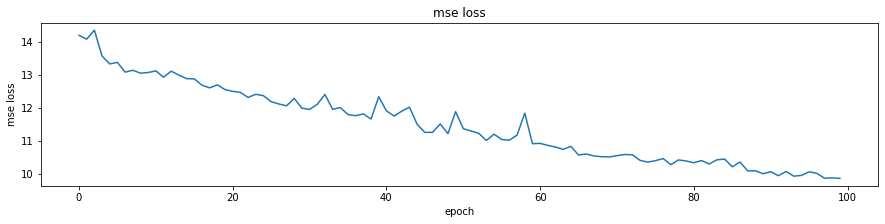

In [13]:
# # print loss
# plt.figure(figsize=(15,3))
# plt.plot(history_model_conv1d.history['mse'])
# plt.title('mse loss')
# plt.xlabel('epoch')
# plt.ylabel('mse loss')

MSE:  9.782270204298515
RMSE:  3.127662098804555
MAE:  2.4571785623344864
R^2:  0.7787823171292843
max absolute error:  10.83532390136719
min absolute error:  0.000854711914065831
mean absolute error:  2.4571785623344864




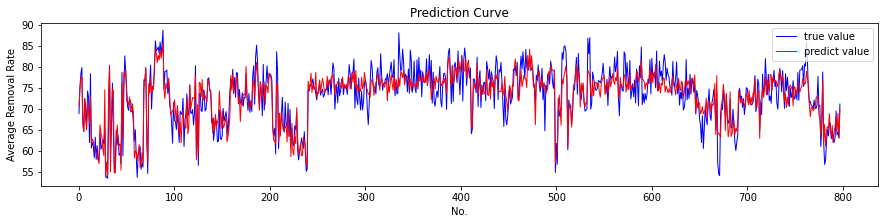

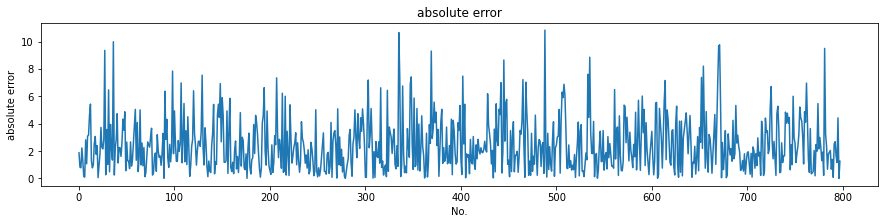

In [14]:
# # predict train set
# y_train_pre = model.predict(X_train)
# PL.plot_predict_curve(y_train, y_train_pre)

MSE:  12.783087631626257
RMSE:  3.5753444074139566
MAE:  2.695425103241891
R^2:  0.6899090069364605
max absolute error:  15.189175195312501
min absolute error:  0.001100573730468568
mean absolute error:  2.695425103241891




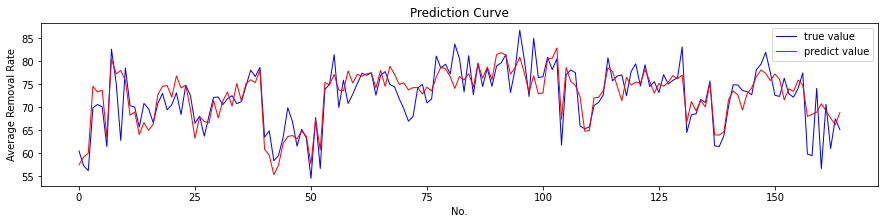

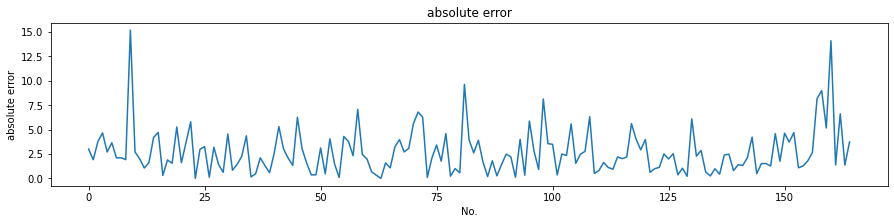

In [15]:
# predict test set
y_test_pre = model.predict(X_test)
PL.plot_predict_curve(y_test, y_test_pre)

<font color='red'>慎重执行保存</font>

In [20]:
# # save model
# model.save('./save_model/modeI_conv1d.h5')

In [17]:
# # save test pre
# pickle.dump(y_test_pre, open('./results_save/predictions_conv1d.pkl', 'wb'))

In [10]:
y_test_pre, mse, rmse, mae, r2, model = predict_conv1d(isPrint=True)

Conv1d model define done
Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d1 (Conv1D)            (None, 262, 256)          9984      
                                                                 
 maxpool1 (MaxPooling1D)     (None, 32, 256)           0         
                                                                 
 conv1d2 (Conv1D)            (None, 31, 128)           65664     
                                                                 
 maxpool2 (MaxPooling1D)     (None, 3, 128)            0         
                                                                 
 conv1d3 (Conv1D)            (None, 2, 64)             16448     
                                                                 
 maxpool3 (MaxPooling1D)     (None, 1, 64)             0         
                                                                 
 flatten (Flatten)           

4/4 [==============================] - 0s 101ms/step - loss: 22.6796 - mse: 22.6796
Epoch 69/400
4/4 [==============================] - 0s 102ms/step - loss: 22.7530 - mse: 22.7530
Epoch 70/400
4/4 [==============================] - 0s 102ms/step - loss: 22.5487 - mse: 22.5487
Epoch 71/400
4/4 [==============================] - 0s 98ms/step - loss: 22.4445 - mse: 22.4445
Epoch 72/400
4/4 [==============================] - 0s 100ms/step - loss: 22.6056 - mse: 22.6056
Epoch 73/400
4/4 [==============================] - 0s 100ms/step - loss: 22.3469 - mse: 22.3469
Epoch 74/400
4/4 [==============================] - 0s 96ms/step - loss: 22.1930 - mse: 22.1930
Epoch 75/400
4/4 [==============================] - 0s 98ms/step - loss: 22.1183 - mse: 22.1183
Epoch 76/400
4/4 [==============================] - 0s 99ms/step - loss: 22.1356 - mse: 22.1356
Epoch 77/400
4/4 [==============================] - 0s 98ms/step - loss: 22.0680 - mse: 22.0680
Epoch 78/400
4/4 [==============================

4/4 [==============================] - 0s 97ms/step - loss: 16.7814 - mse: 16.7814
Epoch 153/400
4/4 [==============================] - 0s 96ms/step - loss: 16.7525 - mse: 16.7525
Epoch 154/400
4/4 [==============================] - 0s 91ms/step - loss: 16.6035 - mse: 16.6035
Epoch 155/400
4/4 [==============================] - 0s 96ms/step - loss: 16.5703 - mse: 16.5703
Epoch 156/400
4/4 [==============================] - 0s 97ms/step - loss: 16.7464 - mse: 16.7464
Epoch 157/400
4/4 [==============================] - 0s 98ms/step - loss: 16.5595 - mse: 16.5595
Epoch 158/400
4/4 [==============================] - 0s 96ms/step - loss: 16.3972 - mse: 16.3972
Epoch 159/400
4/4 [==============================] - 0s 95ms/step - loss: 16.4253 - mse: 16.4253
Epoch 160/400
4/4 [==============================] - 0s 98ms/step - loss: 16.3905 - mse: 16.3905
Epoch 161/400
4/4 [==============================] - 0s 97ms/step - loss: 16.3985 - mse: 16.3985
Epoch 162/400
4/4 [=========================

4/4 [==============================] - 0s 97ms/step - loss: 12.8932 - mse: 12.8932
Epoch 237/400
4/4 [==============================] - 0s 98ms/step - loss: 12.8132 - mse: 12.8132
Epoch 238/400
4/4 [==============================] - 0s 98ms/step - loss: 12.7211 - mse: 12.7211
Epoch 239/400
4/4 [==============================] - 0s 98ms/step - loss: 12.7828 - mse: 12.7828
Epoch 240/400
4/4 [==============================] - 0s 98ms/step - loss: 12.6025 - mse: 12.6025
Epoch 241/400
4/4 [==============================] - 0s 99ms/step - loss: 12.6078 - mse: 12.6078
Epoch 242/400
4/4 [==============================] - 0s 98ms/step - loss: 12.7967 - mse: 12.7967
Epoch 243/400
4/4 [==============================] - 0s 99ms/step - loss: 12.5303 - mse: 12.5303
Epoch 244/400
4/4 [==============================] - 0s 91ms/step - loss: 12.4460 - mse: 12.4460
Epoch 245/400
4/4 [==============================] - 0s 101ms/step - loss: 12.4252 - mse: 12.4252
Epoch 246/400
4/4 [========================

4/4 [==============================] - 0s 95ms/step - loss: 10.5012 - mse: 10.5012
Epoch 321/400
4/4 [==============================] - 0s 97ms/step - loss: 10.4229 - mse: 10.4229
Epoch 322/400
4/4 [==============================] - 0s 98ms/step - loss: 10.5251 - mse: 10.5251
Epoch 323/400
4/4 [==============================] - 0s 98ms/step - loss: 10.8836 - mse: 10.8836
Epoch 324/400
4/4 [==============================] - 0s 98ms/step - loss: 10.7296 - mse: 10.7296
Epoch 325/400
4/4 [==============================] - 0s 97ms/step - loss: 10.1944 - mse: 10.1944
Epoch 326/400
4/4 [==============================] - 0s 93ms/step - loss: 10.3484 - mse: 10.3484
Epoch 327/400
4/4 [==============================] - 0s 96ms/step - loss: 10.3558 - mse: 10.3558
Epoch 328/400
4/4 [==============================] - 0s 100ms/step - loss: 10.5532 - mse: 10.5532
Epoch 329/400
4/4 [==============================] - 0s 98ms/step - loss: 10.5951 - mse: 10.5951
Epoch 330/400
4/4 [========================

## 输出中间层

In [15]:
def explain_intermediate(layer_name, shape):
    layer = model.get_layer(layer_name).output
    intermediate_layer_model = Model(inputs=model.input, outputs=layer)
    # pre train and test for conv1d layer
    output_train = intermediate_layer_model.predict(X_train)
    output_test = intermediate_layer_model.predict(X_test)
    print(output_train.shape)
    print(output_test.shape)
    
    plt.figure(figsize=(12, output_train.shape[2]))
    for i in range(0, output_train.shape[2]):
        plt.subplot(int(output_train.shape[2]/4), 4, i+1)
        plt.imshow(output_train[4,:,i].reshape(shape))
        plt.title(f'Channel-{i}')
    plt.colorbar()
    plt.show()

(798, 1, 64)
(165, 1, 64)


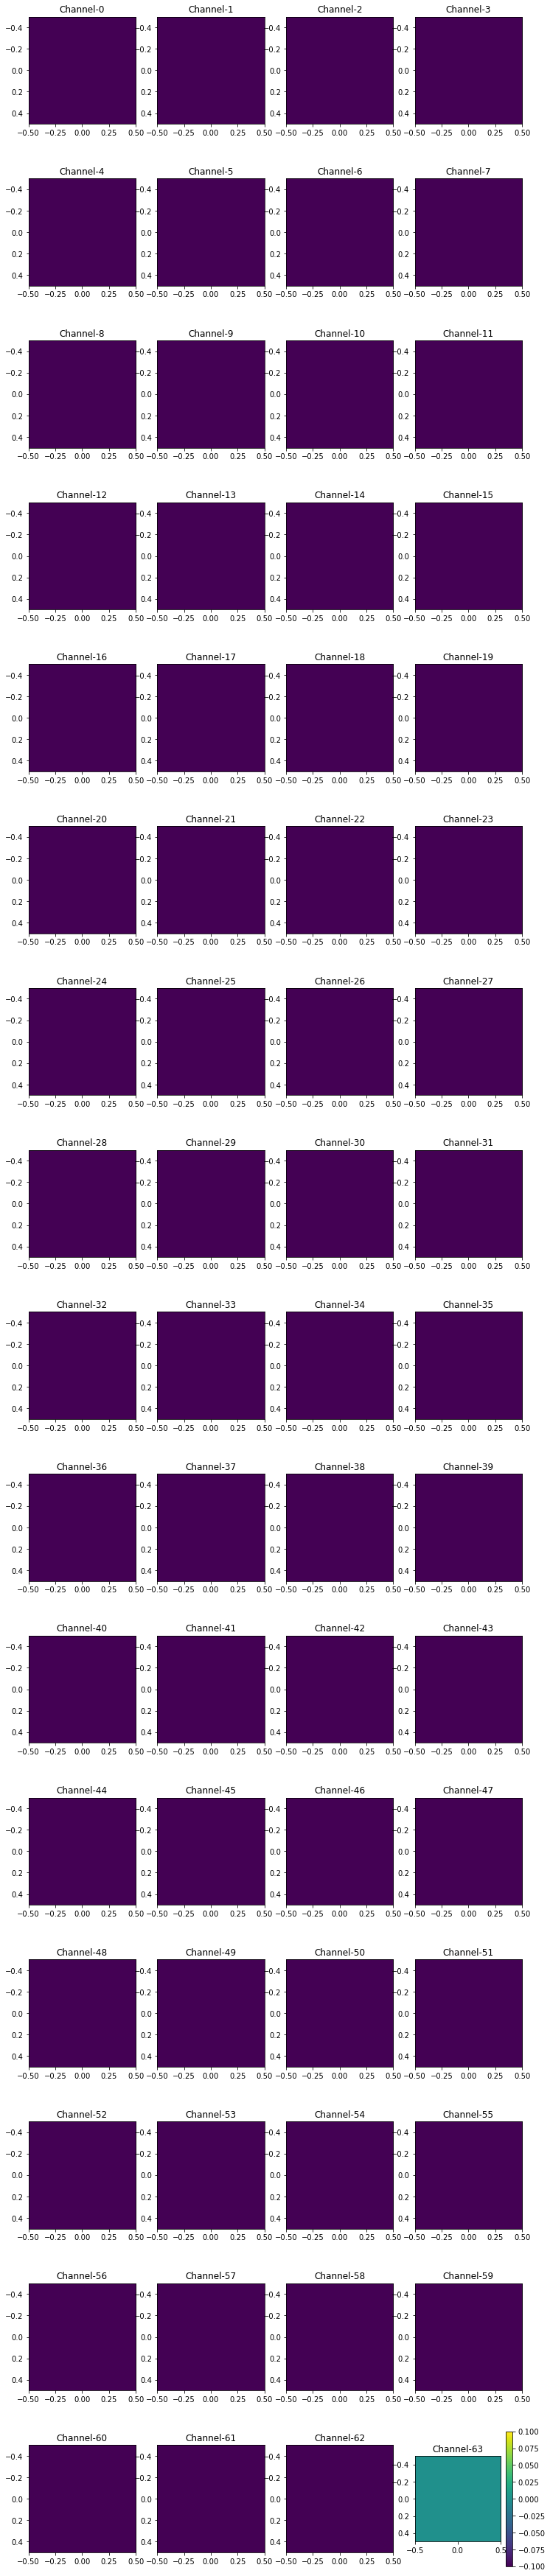

In [16]:
explain_intermediate(layer_name='maxpool3', shape=(1,1))

## 输出conv1d提取的特征
是全连接之前的特征

In [19]:
from keras.models import Model

In [20]:
layer_conv1d = model.get_layer('flatten').output
intermediate_layer_model = Model(inputs=model.input, outputs=layer_conv1d)
# pre train and test for conv1d layer
conv1d_output_train = intermediate_layer_model.predict(X_train)
conv1d_output_test = intermediate_layer_model.predict(X_test)

In [21]:
print(conv1d_output_train.shape)
print(conv1d_output_test.shape)

(798, 64)
(165, 64)


In [22]:
# 保存数组到本地
np.save("./data phm 2016/conv1d_output_train.npy", conv1d_output_train)
np.save("./data phm 2016/conv1d_output_test.npy", conv1d_output_test)

## conv1d+SAE
conv1d的特征输出作为SAE第一个AE的输入

In [23]:
# define model 
# 文兰硕士论文给出的SAE结构和参数
# activation=tanh SAE_hidden_unit=[20,15]，第一步无监督分层训练adadelta-200epoch，第二步有监督微调sgd-20epoch+RMSprop-400epoch early_stopping, reduce_lr

In [38]:
# step1：无监督分层训练
# hyperparameters

# number of wafers as number of inputs
n_inputs = 64 # conv1d模型特征个数
n_outputs = n_inputs

# number of hidden layers
n_layers = 2
# neurons in each hidden layer
n_neurons = [20,15]
# add decoder layers:
n_neurons.extend(list(reversed(n_neurons)))
n_layers = n_layers * 2

model_conv1d_SAE = Sequential(name='model_conv1d_SAE')

# add input to first layer
model_conv1d_SAE.add(Dense(units=n_neurons[0], activation='relu', input_shape=(n_inputs,), name='dense0'))

for i in range(1,n_layers):
    model_conv1d_SAE.add(Dense(units=n_neurons[i], activation='relu', name='dense'+str(i)))
    
# add last layer as output layer
model_conv1d_SAE.add(Dense(units=n_outputs, activation='tanh', name='dense'+str(n_layers)))
model_conv1d_SAE.summary()

Model: "model_conv1d_SAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense0 (Dense)               (None, 20)                1300      
_________________________________________________________________
dense1 (Dense)               (None, 15)                315       
_________________________________________________________________
dense2 (Dense)               (None, 15)                240       
_________________________________________________________________
dense3 (Dense)               (None, 20)                320       
_________________________________________________________________
dense4 (Dense)               (None, 64)                1344      
Total params: 3,519
Trainable params: 3,519
Non-trainable params: 0
_________________________________________________________________


In [39]:
# compile
model_conv1d_SAE.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [40]:
# fit SAE
n_epochs = 100
batch_size = 200
history_conv1d_SAE = model_conv1d_SAE.fit(conv1d_output_train, conv1d_output_train, batch_size=batch_size, epochs=n_epochs)

Epoch 1/100
4/4 [==============================] - 1s 2ms/step - loss: 25.6415 - mse: 25.6415
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 25.0478 - mse: 25.0478
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 24.3853 - mse: 24.3853
Epoch 4/100
4/4 [==============================] - 0s 2ms/step - loss: 23.7719 - mse: 23.7719
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 23.3650 - mse: 23.3650
Epoch 6/100
4/4 [==============================] - 0s 1ms/step - loss: 22.9992 - mse: 22.9992
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 22.5884 - mse: 22.5884
Epoch 8/100
4/4 [==============================] - 0s 2ms/step - loss: 22.0600 - mse: 22.0600
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 21.7372 - mse: 21.7372
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 21.3034 - mse: 21.3034
Epoch 11/100
4/4 [==============================] - 0s 1ms/

Text(0, 0.5, 'mse loss')

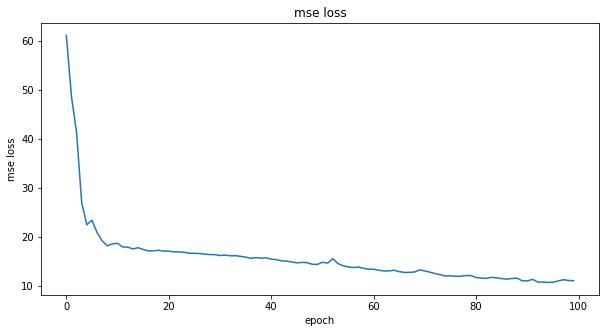

In [41]:
# plot loss
plt.figure(figsize=(10,5))
plt.plot(history_model_conv1d.history['mse'])
plt.title('mse loss')
plt.xlabel('epoch')
plt.ylabel('mse loss')

In [45]:
# step2: 有监督微调
# 重新构建一个model
layer_SAE_dense1 = model_conv1d_SAE.get_layer('dense1').output
layer_dense_output = Dense(1, name='dense_output')(layer_SAE_dense1)
model_conv1d_SAE2 = Model(inputs=model_conv1d_SAE.input, outputs=layer_dense_output, name='model_biLSTM_SAE2')
print(model_conv1d_SAE2.summary())

Model: "model_biLSTM_SAE2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense0_input (InputLayer)    [(None, 64)]              0         
_________________________________________________________________
dense0 (Dense)               (None, 20)                1300      
_________________________________________________________________
dense1 (Dense)               (None, 15)                315       
_________________________________________________________________
dense_output (Dense)         (None, 1)                 16        
Total params: 1,631
Trainable params: 1,631
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
# compile
model_conv1d_SAE2.compile(loss='mse', optimizer='adam', metrics=['mse'])

Epoch 1/50
4/4 [==============================] - 0s 1ms/step - loss: 4719.2308 - mse: 4719.2312
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 4187.8217 - mse: 4187.8217
Epoch 3/50
4/4 [==============================] - 0s 1ms/step - loss: 3721.3102 - mse: 3721.3102
Epoch 4/50
4/4 [==============================] - 0s 1ms/step - loss: 3302.3675 - mse: 3302.3675
Epoch 5/50
4/4 [==============================] - 0s 954us/step - loss: 2886.3078 - mse: 2886.3078
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 2500.0905 - mse: 2500.0905
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - loss: 2139.3699 - mse: 2139.3699
Epoch 8/50
4/4 [==============================] - 0s 979us/step - loss: 1798.4387 - mse: 1798.4387
Epoch 9/50
4/4 [==============================] - 0s 1ms/step - loss: 1502.6518 - mse: 1502.6518
Epoch 10/50
4/4 [==============================] - 0s 1ms/step - loss: 1217.2171 - mse: 1217.2171
Epoch 11/50
4/4 [========

Text(0, 0.5, 'mse loss')

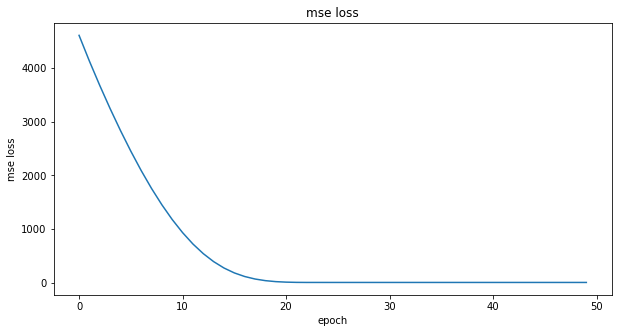

In [47]:
# fit
history_conv1d_SAE2 = model_conv1d_SAE2.fit(conv1d_output_train, y_train, epochs=50, batch_size=200)
# plot model loss
# plot loss
plt.figure(figsize=(10,5))
plt.plot(history_conv1d_SAE2.history['mse'])
plt.title('mse loss')
plt.xlabel('epoch')
plt.ylabel('mse loss')

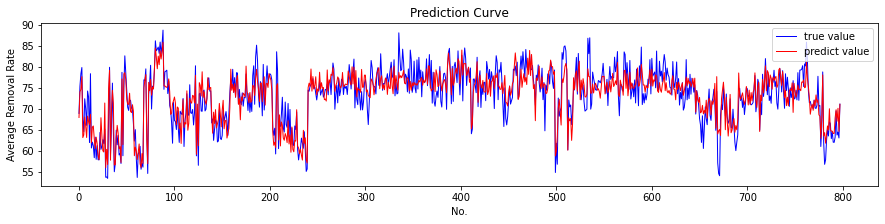

MSE:  10.29371587099766
RMSE:  3.2083821267108537
MAE:  2.5562252731514454
R^2:  0.7672164103470593
max absolute error:  11.091663928222658
min absolute error:  0.014194604492189455
mean absolute error:  2.5562252731514454


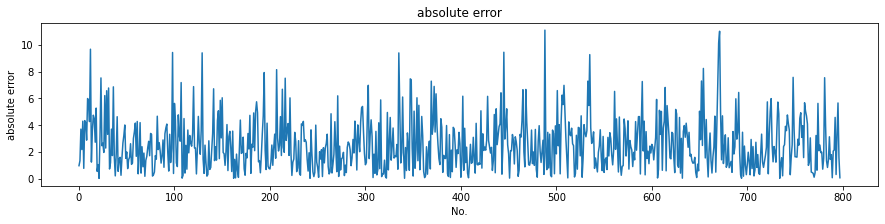

In [48]:
y_train_pre = model_conv1d_SAE2.predict(conv1d_output_train)
PL.plot_predict_curve(y_train, y_train_pre)

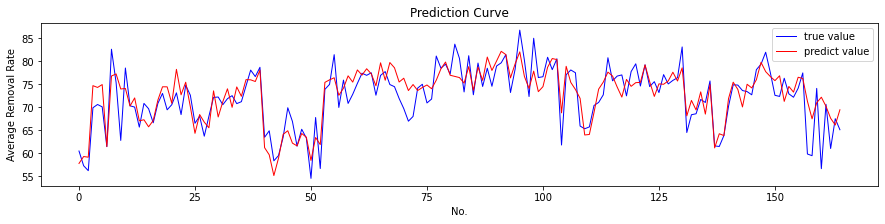

MSE:  12.700319226972965
RMSE:  3.5637507245839974
MAE:  2.7414837282862803
R^2:  0.691916795471816
max absolute error:  15.527844201660159
min absolute error:  0.00705244140625183
mean absolute error:  2.7414837282862803


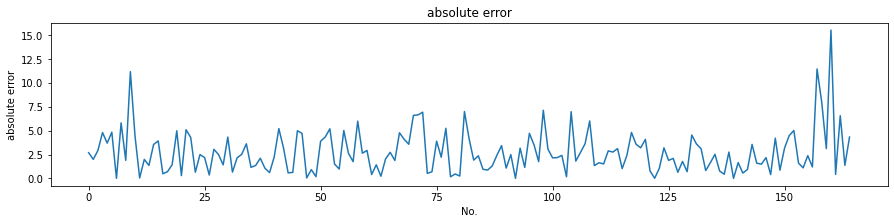

In [49]:
y_test_pre = model_conv1d_SAE2.predict(conv1d_output_test)
PL.plot_predict_curve(y_test, y_test_pre)